## Einführung in LangGraph mit einem einfachen StateGraph-Beispiel

In diesem Workshop verwenden wir **LangGraph** und zeigen, wie man einen `StateGraph` aufsetzt, einen einzelnen "Agenten" erstellt und damit einfache Berechnungen (in unserem Fall eine Multiplikation) durchführt.

### 1. Imports
In dieser Zelle importieren wir die notwendigen Klassen und Funktionen.
- `START` und `END` sind spezielle Marker, die den Anfang und das Ende eines Graphen repräsentieren.
- `StateGraph` ist die zentrale Klasse von LangGraph, die unseren Workflow konfiguriert.
- `TypedDict` hilft uns dabei, den "State" (Zustand) typisiert anzulegen, was den Code besser verständlich macht und potenzielle Fehler frühzeitig erkennen lässt.
 - `IPython.display` wird genutzt, um innerhalb von Jupyter Notebooks Grafiken anzuzeigen (z.B. unser Graph-Diagramm).

In [2]:
from langgraph.graph import START, StateGraph, END
from typing_extensions import TypedDict
from IPython.display import Image, display

### 2. State definieren
Anschließend definieren wir unseren State `MyState` als `TypedDict`. Er enthält:

- `number_a` und `number_b`: Die Eingabezahlen.
- `result`: Das Ergebnis der Multiplikation.

Der State dient als Eingabeschema für alle *Nodes* und *Edges* im Graphen.

In [3]:
# State definieren
class MyState(TypedDict):
    number_a: int
    number_b: int
    result: int

### 3. Node definieren

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) sind einfach Python-Funktionen.

Das erste Positionsargument ist der **state**, wie oben definiert.

Da der **state** ein `TypedDict` mit dem oben definierten Schema ist, kann jede Node auf die Schlüssel `number_a` und `number_b` mit `state['number_a']` und `state['number_b']` zugreifen.

Jeder Node gibt einen neuen Wert des State-Schlüssels `graph_state` zurück.

Standardmäßig überschreibt der neue von jedem Node zurückgegebene Wert den vorherigen Wert des States.

In [4]:
# Erste Node erstellen
def multiply_two_numbers(state: MyState): 
    result = state["number_a"] * state["number_b"]

    return {"result": result}

#### Erklärung
Wir erstellen eine Funktion `multiply_two_numbers`, die in unserem Graph als *Node* eingebunden wird.

- Sie nimmt den State entgegen (als Dictionary).
- Führt die Multiplikation durch.
- Gibt ein Dictionary mit dem Schlüssel `"result"` zurück, das automatisch in den State übernommen wird.

### 4. Graph definieren 

Jetzt erstellen wir den Graph aus unseren [Components](https://langchain-ai.github.io/langgraph/concepts/low_level/), die wir oben definiert haben.

Die [StateGraph-Klasse](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) ist die Graph-Klasse, die wir verwenden können.

Zuerst initialisieren wir einen **StateGraph** mit der **MyState**-Klasse, die wir oben definiert haben.

Dann fügen wir unsere Nodes und Edges hinzu.

Edges verbinden Nodes miteinander.

Wir verwenden den [`START` Node, einen speziellen Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node), der Benutzereingaben an den Graph sendet, um anzugeben, wo unser Graph beginnt.

Der [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) ist ein spezieller Node, der einen terminalen Node darstellt.

Abschließend [kompilieren wir unseren Graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph), um ein paar grundlegende Überprüfungen der Graph-Struktur durchzuführen.

In [5]:
# StateGraph initialisieren
graph = StateGraph(MyState)

# Agent (Node) hinzufügen
graph.add_node("Multiply", multiply_two_numbers)

# Ablauf im Graph definieren durch Edges
graph.add_edge(START, "Multiply")
graph.add_edge("Multiply", END)

# Graph erstellen
graph = graph.compile()

#### Erklärung
- Wir erzeugen eine Instanz `StateGraph(MyState)`, die unseren typisierten State übernimmt.
- Dann fügen wir eine Node hinzu (mit `add_node`), welche auf unsere Funktion `multiply_two_numbers` verweist.
- Mit `add_edge` legen wir die Ablaufreihenfolge fest: Zuerst `START`, dann `"Multiply"`, dann `END`.
- Zum Schluss verwenden wir `compile()`, damit LangGraph unseren Graphen finalisiert und für die Ausführung vorbereitet.


### 6. Graph visualisieren
Wir lassen uns den Graph in Form einer Mermaid-Grafik anzeigen. Das hilft uns zu verstehen, wie der Ablauf (`START -> Multiply -> END`) aussieht. 

Diese Grafik kann nur in Jupyter Notebooks (oder ähnlichen Umgebungen) gerendert werden, in reinen Python-Skripten wäre das anders zu handhaben.


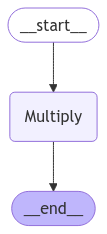

In [6]:
# Graph anzeigen lassen
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### 5. Graph aufrufen

Nun müssen wir nur noch den Graphen aufrufen, den wir eben definiert haben. Dafür rufen wir die Methode `invoke` mit den Eingabe Parametern als Dictionary auf. 

Wenn wir `debug=True` setzen, dann sehen wir die Zwischenschritte des Graphen.

In [9]:
# Graph aufrufen
result_state = graph.invoke({
                        "number_a": 3,
                        "number_b": 55},
                        debug=True)

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'number_a': 3, 'number_b': 55}
[0:writes] Finished step 0 with writes to 2 channels:
- number_a -> 3
- number_b -> 55
[0:checkpoint] State at the end of step 0:
{'number_a': 3, 'number_b': 55}
[1:tasks] Starting 1 task for step 1:
- Multiply -> {'number_a': 3, 'number_b': 55}
[1:writes] Finished step 1 with writes to 1 channel:
- result -> 165
[1:checkpoint] State at the end of step 1:
{'number_a': 3, 'number_b': 55, 'result': 165}


#### Erklärung

- Die Daten fließen durch den Graph von `START` zur Node `"Multiply"`.
- Dort wird `number_a * number_b` berechnet und das Ergebnis in den State geschrieben.
- Anschließend geht es zum `END`.
- Wir nutzen `debug=True`, um zusätzliche Debug-Informationen auszugeben.

### 6. Ergebnis ausgeben

In [8]:
# Ergebnis ausgeben
print(f"Das Ergebnis lautet: {result_state["result"]}")

Das Ergebnis lautet: 165


## Zusammenfassung

Wir haben gelernt: 
1. Wie man mit **LangGraph** ein `StateGraph` aufbaut.
2. Eine **Node** (Funktion) erstellt, die auf den State zugreift und Daten verändert.
3. Wie man **Edges** (`add_edge`) setzt, um den Ablauf zu definieren.
4. Wie man den Graphen **ausführt** und schließlich **Ergebnisse** aus dem State ausliest.

Du kannst diesen Ansatz erweitern, um komplexere Workflows zu bauen, z. B. indem du mehrere Nodes für unterschiedliche Berechnungen oder Logik-Schritte einbaust. 

Viel Spaß beim Experimentieren!

### Weitere Resourcen 
- https://academy.langchain.com/
- https://github.com/langchain-ai/langchain-academy
